# LSTM

In [1]:
import torch
from torch import nn
import d2l.torch as d2l
import numpy as np

batch_size, num_hiddens, data_len = 32, 256, 64

In [2]:
input_x = np.loadtxt('train_feature.csv', delimiter=',')
input_y = np.loadtxt('train_label.csv', delimiter=',')
test_x = np.loadtxt('test_feature.csv', delimiter=',')
test_y = np.loadtxt('test_label.csv', delimiter=',')

def load_array(data_arrays, batch_size, is_train=True):
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train, drop_last=True)

train_iter = load_array((torch.tensor(input_x), torch.tensor(input_y, dtype=torch.int64)), batch_size)
test_iter = load_array((torch.tensor(test_x), torch.tensor(test_y, dtype=torch.int64)), batch_size)

In [3]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.LSTM1 = nn.LSTM(1, 256, batch_first=True)
        self.LSTM2 = nn.LSTM(256, 128, batch_first=True)
        self.LSTM3 = nn.LSTM(128, 64, batch_first=True)
        self.LSTM4 = nn.LSTM(64, 32, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(data_len * 32, 256), nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 32), nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 2)
        )
    
    def get_state(self, layers, batch_size, hiddens):
        return torch.zeros((layers, batch_size, hiddens), device=d2l.try_gpu())
    
    def forward(self, inputs):
        X = inputs.unsqueeze(2).to(torch.float32) # 在最后插入一个维度, feature
        Y, state = self.LSTM1(X)
        Y, state = self.LSTM2(Y)
        Y, state = self.LSTM3(Y)
        Y, state = self.LSTM4(Y)
        return self.mlp(Y)

In [4]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

def train_epoch(net, train_iter, loss, updater, device):
    net.train()
    state = None
    metric = d2l.Accumulator(3)
    for X, Y in train_iter:
        X, Y = X.to(device), Y.to(device)
        y_hat = net(X)
        l = loss(y_hat, Y.long()).mean()
        updater.zero_grad()
        l.backward()
        d2l.grad_clipping(net, 1)
        updater.step()
        metric.add(float(l.sum() * X.shape[0]), accuracy(y_hat, Y), Y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

def evaluate_accuracy_gpu(net, data_iter, device):
    net.eval()
    metric = d2l.Accumulator(3)
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

def train(net, train_iter, lr, num_epochs, device=d2l.try_gpu()):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.5, 1.0], legend=['train loss', 'train acc', 'test acc'])
    updater = torch.optim.SGD(net.parameters(), lr)
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater, device)
        test_acc = evaluate_accuracy_gpu(net, test_iter, d2l.try_gpu())
        animator.add(epoch + 1, train_metrics + (test_acc,))
    print(f'train acc is {train_metrics[1]:.4f}\n test acc is {test_acc:.4f}')

train acc is 0.9033
 test acc is 0.7611


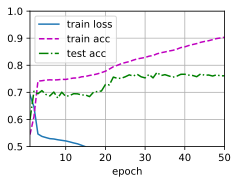

In [5]:
num_epochs, lr = 50, 0.1
net = LSTMModel().to(d2l.try_gpu())
train(net, train_iter, lr, num_epochs, d2l.try_gpu())